In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from pathlib import Path

In [3]:
def readucr_space_separated(filename):
    """
    Read UCR dataset format with space delimiter (for FordB .txt files)
    """
    data = np.loadtxt(filename, delimiter=None)  # None means any whitespace
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

# Use the space-separated files directly
train_file = r"C:\Users\yoges\OneDrive\UvA\Courses\Master's Thesis\CODE\data\FordB\FordB_TRAIN.txt"
test_file = r"C:\Users\yoges\OneDrive\UvA\Courses\Master's Thesis\CODE\data\FordB\FordB_TEST.txt"

print(f"Loading train file: {train_file}")
print(f"Loading test file: {test_file}")

# Load FordB training and test data with the correct function
x_train, y_train = readucr_space_separated(train_file)
x_test, y_test = readucr_space_separated(test_file)

print(f"Successfully loaded FordB dataset!")
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Training labels: {np.unique(y_train)}")
print(f"Test labels: {np.unique(y_test)}")

Loading train file: C:\Users\yoges\OneDrive\UvA\Courses\Master's Thesis\CODE\data\FordB\FordB_TRAIN.txt
Loading test file: C:\Users\yoges\OneDrive\UvA\Courses\Master's Thesis\CODE\data\FordB\FordB_TEST.txt
Successfully loaded FordB dataset!
Training data shape: (3636, 500)
Test data shape: (810, 500)
Training labels: [-1  1]
Test labels: [-1  1]


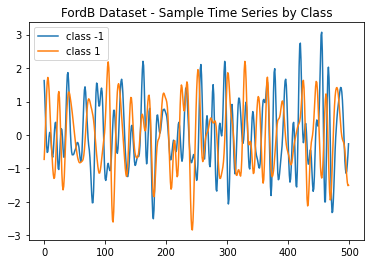

In [5]:
# Continue with your original code
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.title("FordB Dataset - Sample Time Series by Class")
plt.show()
plt.close()

In [7]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

num_classes = len(np.unique(y_train))

# Shuffle training data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# Convert labels from -1/1 to 0/1
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [9]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

model = make_model(input_shape=x_train.shape[1:])

In [11]:
epochs = 300
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "models/best_model_fordb.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/300
91/91 [==============================] - 8s 77ms/step - loss: 0.4481 - sparse_categorical_accuracy: 0.8078 - val_loss: 0.9522 - val_sparse_categorical_accuracy: 0.4766
Epoch 2/300
91/91 [==============================] - 7s 76ms/step - loss: 0.3499 - sparse_categorical_accuracy: 0.8525 - val_loss: 1.2269 - val_sparse_categorical_accuracy: 0.4766
Epoch 3/300
91/91 [==============================] - 7s 80ms/step - loss: 0.3418 - sparse_categorical_accuracy: 0.8590 - val_loss: 1.0063 - val_sparse_categorical_accuracy: 0.4766
Epoch 4/300
91/91 [==============================] - 8s 84ms/step - loss: 0.3084 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.7417 - val_sparse_categorical_accuracy: 0.4918
Epoch 5/300
91/91 [==============================] - 7s 78ms/step - loss: 0.3177 - sparse_categorical_accuracy: 0.8566 - val_loss: 0.6261 - val_sparse_categorical_accuracy: 0.6923
Epoch 6/300
91/91 [==============================] - 8s 84ms/step - loss: 0.3016 - sparse_categorica

In [12]:
model = keras.models.load_model("models/best_model_fordb.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("FordB Test accuracy", test_acc)
print("FordB Test loss", test_loss)

26/26 [==============================] - 1s 16ms/step - loss: 0.4469 - sparse_categorical_accuracy: 0.7901
FordB Test accuracy 0.790123462677002
FordB Test loss 0.4469479024410248


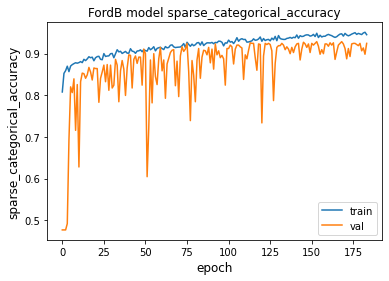

In [13]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("FordB model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [14]:
np.savez("data/fordb_data.npz", 
         x_train=x_train,
         x_test=x_test,
         y_train=y_train,
         y_test=y_test)

print("Saved: fordb_data.npz with keys: 'x_train', 'x_test', 'y_train', 'y_test'")

Saved: fordb_data.npz with keys: 'x_train', 'x_test', 'y_train', 'y_test'


In [38]:
print("GOOD MORNING!!")

GOOD MORNING!!
